In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.11" "tensorflow_probability==0.19"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
my_path = None
if i!=-1:
    my_path = p[:i]
    import sys
    sys.path.append(my_path)
    print("SageMaker: added python path %s" % my_path)
else:
    print(sys.path)

SageMaker: added python path /Users/lisafaloughi/Desktop/DeepHedging


In [ ]:
import pickle

with open("results.pkl", "wb") as f:
    pickle.dump(results, f)

Tensorflow version 2.13.0 running on 1 CPUs and 0 GPUs

 Training with 10 prototypes...
Initializing training at 2025-07-15 07:56:44: gym with 27 trainable weights compiled. Took 1s
ProtoAgent using 25 trainable weights for 2 instruments.
Features used: delta, price and time_left
Monetary utility cvar@1 is using 1 weight
 Features available: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_stoch_10_weights_trained_v1/21a1bb6a367d551aaa3acda8f9e2c324a1fe738557e3e312.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_stoch_10_weights_trained_v1/21a1bb6a367d551aaa3acda8f9e2c324a1fe738557e3e312.pck was trained for 800 epochs; you have asked to train for 800 epochs. If you wan

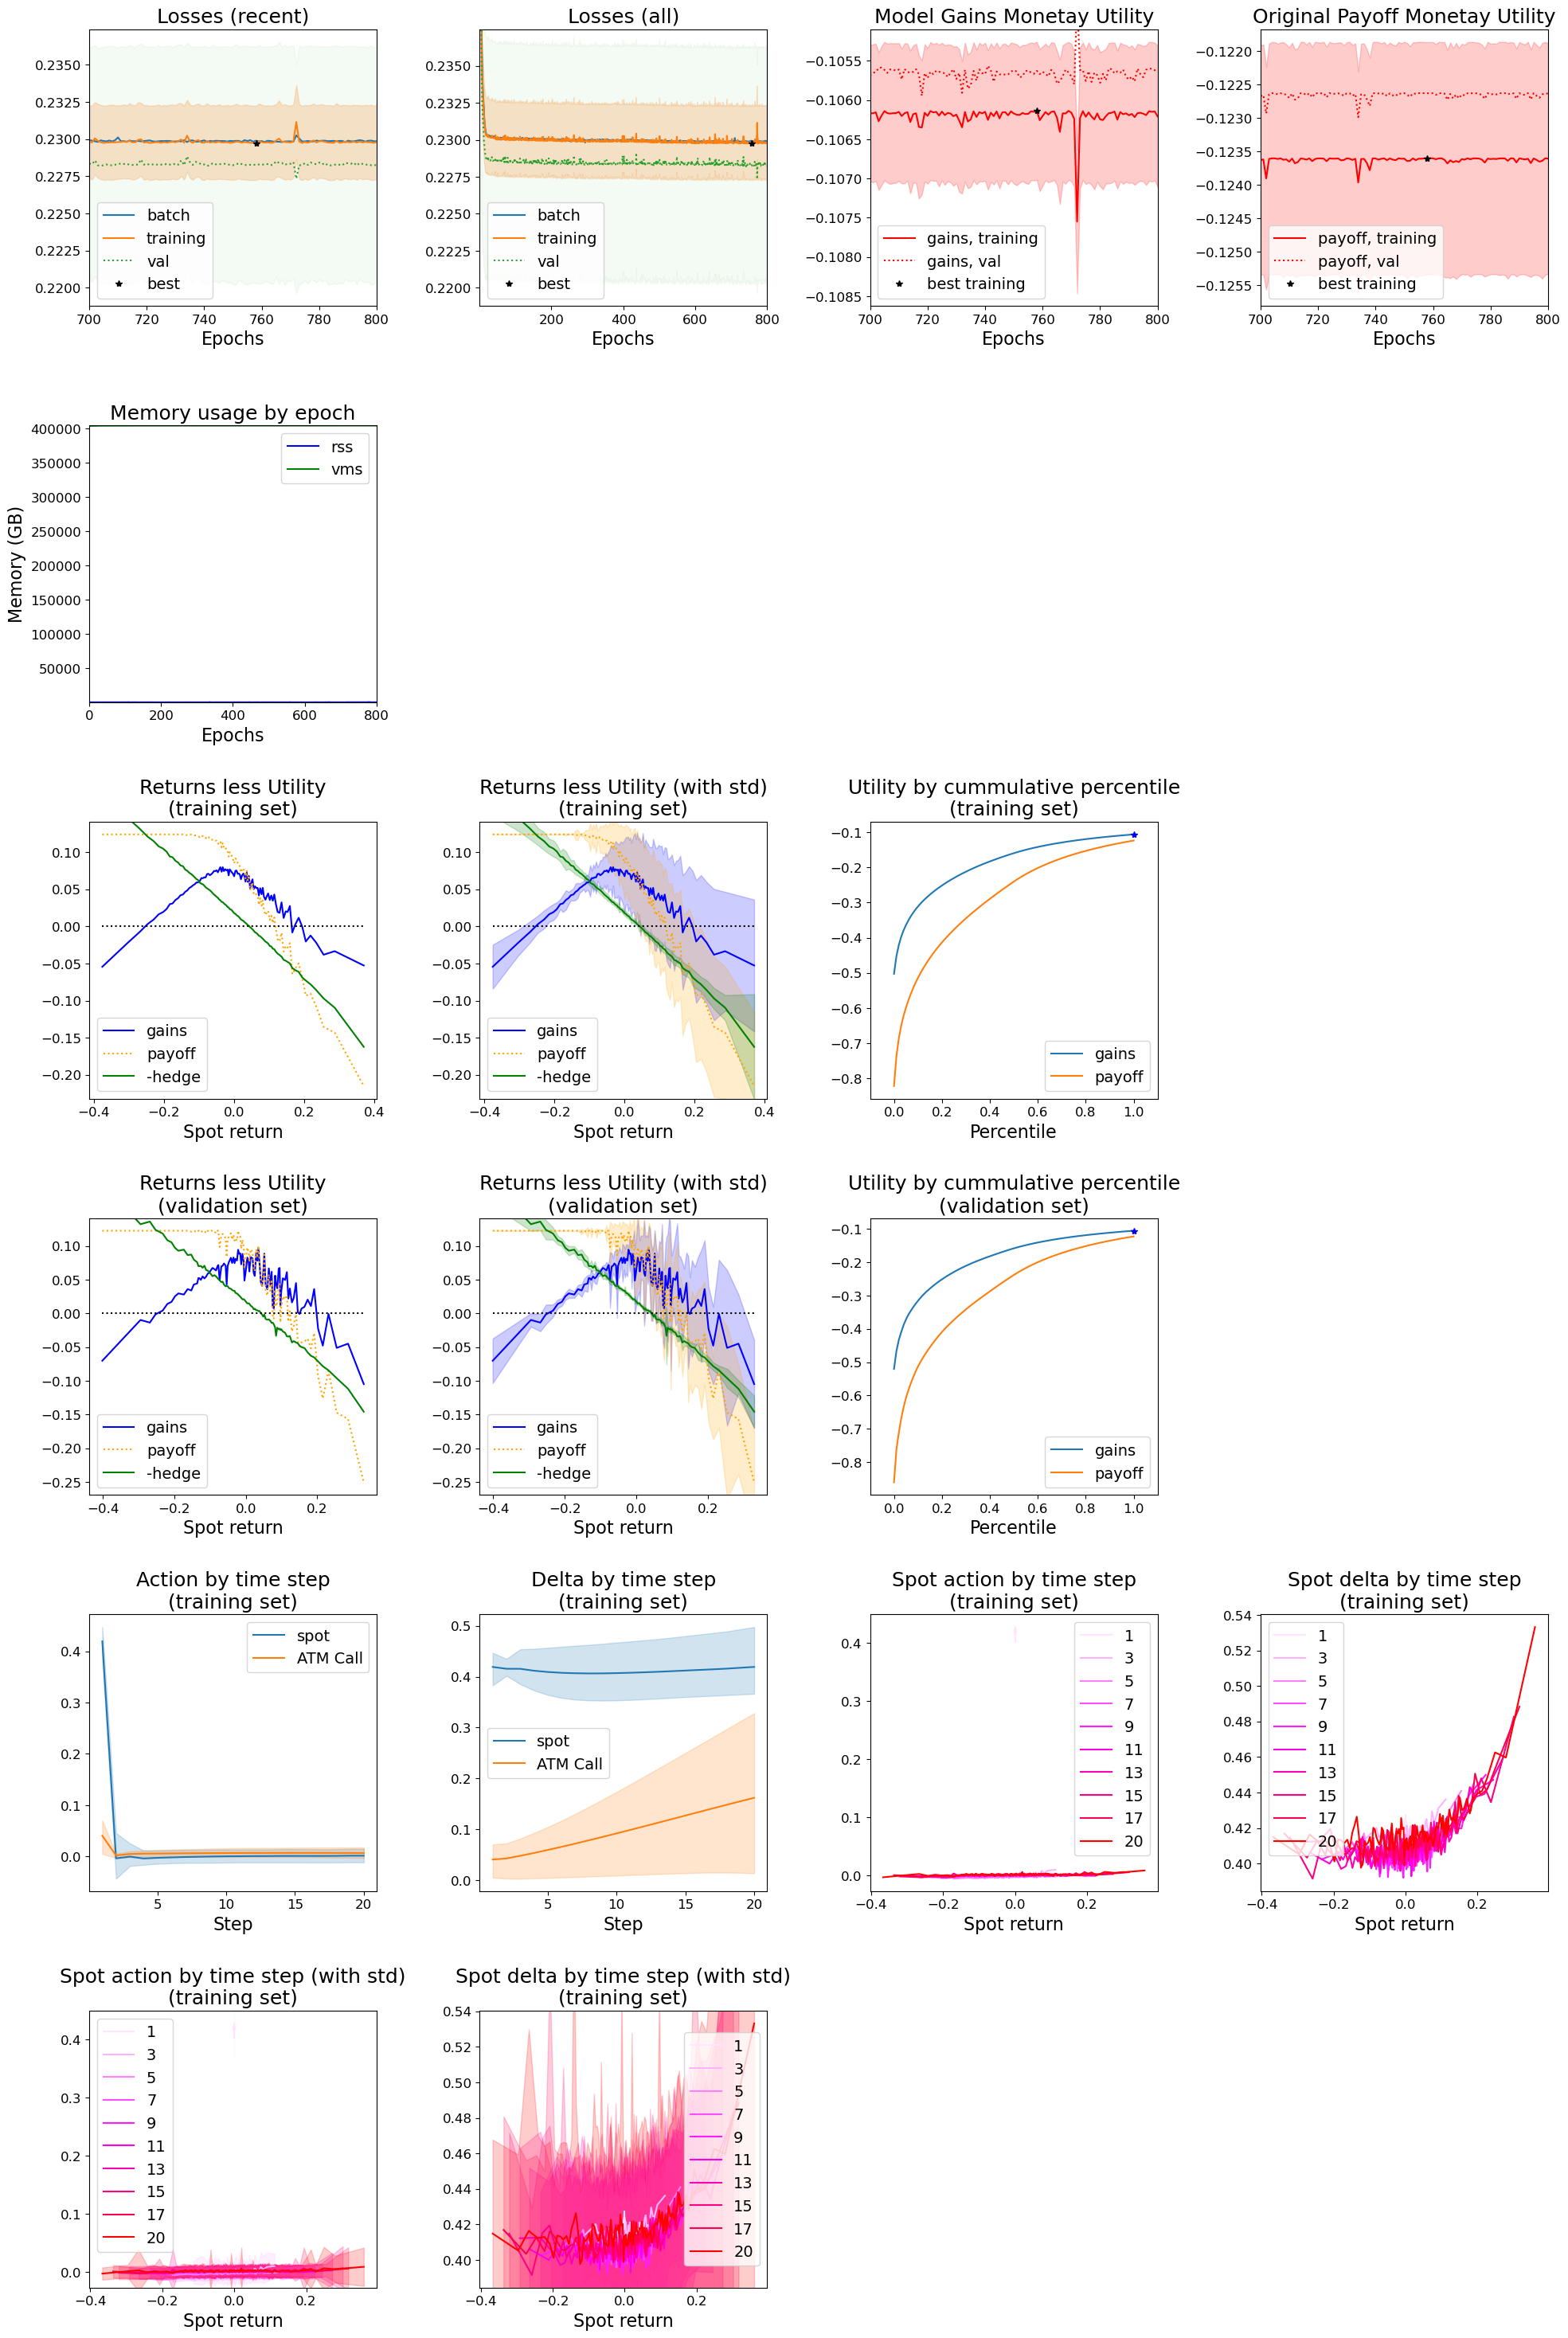

Training 800/800 epochs; 27 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.759313 (0.0107044), training 0.229818 (0.00251494), best 0.229741 (0.0107044), batch 0.229854, val 0.228258 (0.00800439); best epoch 758, last cached 800 | memory used: rss 184.578M, vms 403953M | time elapsed 38:26; time per epoch 2s; estimated time remaining 0s | current time: 2025-07-15 07:56:46                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 758
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_stoch_10_weights_trained_v1/21a1bb6a367d551aaa3acda8f9e2c324a1fe738557e3e312.pck
 Time: 2025-07-15 07:56:47
Training terminated. Total time taken 3s
✅ Seed 1 | Prototypes 10: Mean utility = -0.107571
prototype 10 feature weights: [3.4934943e+00 4.9798164e-01 3.8842865e-34 6.4140296e-01 3.7187668e-34]


In [ ]:
# In your notebook or training script:

import pickle
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.trainer import train
from deephedging.world import SimpleWorld_Spot_ATM
from cdxbasics.config import Config

n_prototypes_list = [10, 30, 50, 100, 500, 750, 1000, 1500 ]

seeds = [1]  # You can increase this list

results = {}

for fixed_seed in seeds:
    if fixed_seed not in results:
        results[fixed_seed] = {}  

    # === 1. Load config and create fixed test world once ===
    base_config = Config()
    base_config.world.samples = 10000
    base_config.world.steps = 20
    base_config.world.black_scholes = False
    base_config.world.seed = fixed_seed  # Ensures repeatable test world
    test_world = SimpleWorld_Spot_ATM(base_config.world).clone(samples=5000)
    test_data = test_world.tf_data  # Shared test set for all runs

    for n_prototypes in n_prototypes_list:
        print(f"\n Training with {n_prototypes} prototypes...")

        # 1. Load configuration
        config = Config()

        # 2. World setup
        config.world.samples = 10000
        config.world.steps = 20
        config.world.black_scholes = False

        # 3. Gym setup with ProtoAgent
        config.gym.agent.agent_type = "protopnet"  # Tells AgentFactory to use ProtoAgent
        config.gym.agent.features = ["price", "delta", "time_left"]  # Must match prototype dimensions
        config.gym.agent.prototype_path = f"./prototypes_storage/prototypes_stochastic_{n_prototypes}.pkl"
        config.gym.objective.utility = "cvar"
        config.gym.objective.lmbda = 1.

        # 5. Trainer config
        config.trainer.train.epochs = 800
        config.trainer.caching.mode = "on"  # Important to avoid reusing old cache
        config.trainer.caching.directory = f"./.deephedging_cache/proto_stoch_{n_prototypes}_weights_trained_v1"
        config.trainer.visual.epoch_refresh = 5

        config.trainer.train.optimizer.name = "adam"
        config.trainer.train.optimizer.learning_rate = 0.001
        config.trainer.train.optimizer.clipvalue = 1.
        config.trainer.train.optimizer.global_clipnorm = 1.
        config.trainer.train.batch_size = None
        config.trainer.visual.confidence_pcnt_lo = 0.25
        config.trainer.visual.confidence_pcnt_hi = 0.75

        # 6. Build world & val_world
        world = SimpleWorld_Spot_ATM(config.world)
        val_world = world.clone(samples=world.nSamples // 10)

        # 7. Create the gym (automatically uses ProtoAgent via AgentFactory)
        gym = VanillaDeepHedgingGym(config.gym)

        # 8. Train the model using the prototype-based agent
        train(gym=gym, world=world, val_world=val_world, config=config.trainer)

        # r = gym(world.tf_data)

        # print("Keys of the dictionary returned by the gym: ", r.keys())

        # print("=========================================")
        # print("Config usage report")
        # print("=========================================")
        # print( config.usage_report() )
        config.done()

        # 9. Evaluate
        test_result = gym(test_data)
        mean_utility = test_result["utility"].numpy().mean()

        # results[n_prototypes] = {
        #     "test_result": test_result
        # }
        results[fixed_seed][n_prototypes] = mean_utility

        # Free memory
        del test_result
        import gc
        gc.collect()

        # print(f"✅ Finished {n_prototypes} prototypes: Mean utility = {mean_utility:.6f}")
        print(f"✅ Seed {fixed_seed} | Prototypes {n_prototypes}: Mean utility = {mean_utility:.6f}")

        agent = gym.agent
        proto_layer = agent.proto_layer
        prototypes = proto_layer.prototypes.numpy()
        proto_actions = proto_layer.prototype_actions.numpy()

        # 7. Convert prototypes and actions to tensors
        feature_weights = proto_layer.feature_weights.numpy()
        print(f"prototype {n_prototypes} feature weights: {feature_weights}")





In [ ]:
# In your notebook or training script:

import pickle
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.trainer import train
from deephedging.world import SimpleWorld_Spot_ATM
from cdxbasics.config import Config

n_prototypes_list = [10, 30, 50, 100, 250, 500, 600, 750, 1000, 1500, 2000, 2500, 3000, 3750]

seeds = [i for i in range(21,51)]  # You can increase this list

for fixed_seed in seeds:
    if fixed_seed not in results:
        results[fixed_seed] = {}  

    # === 1. Load config and create fixed test world once ===
    base_config = Config()
    base_config.world.samples = 10000
    base_config.world.steps = 20
    base_config.world.black_scholes = False
    base_config.world.seed = fixed_seed  # Ensures repeatable test world
    test_world = SimpleWorld_Spot_ATM(base_config.world).clone(samples=5000)
    test_data = test_world.tf_data  # Shared test set for all runs

    for n_prototypes in n_prototypes_list:
        print(f"\n Training with {n_prototypes} prototypes...")

        # 1. Load configuration
        config = Config()

        # 2. World setup
        config.world.samples = 10000
        config.world.steps = 20
        config.world.black_scholes = False

        # 3. Gym setup with ProtoAgent
        config.gym.agent.agent_type = "protopnet"  # Tells AgentFactory to use ProtoAgent
        config.gym.agent.features = ["price", "delta", "time_left"]  # Must match prototype dimensions
        config.gym.agent.prototype_path = f"./prototypes_storage/prototypes_stochastic_{n_prototypes}.pkl"
        config.gym.objective.utility = "cvar"
        config.gym.objective.lmbda = 1.

        # 5. Trainer config
        config.trainer.train.epochs = 800
        config.trainer.caching.mode = "on"  # Important to avoid reusing old cache
        config.trainer.caching.directory = f"./.deephedging_cache/proto_stoch_{n_prototypes}"
        config.trainer.visual.epoch_refresh = 5

        config.trainer.train.optimizer.name = "adam"
        config.trainer.train.optimizer.learning_rate = 0.001
        config.trainer.train.optimizer.clipvalue = 1.
        config.trainer.train.optimizer.global_clipnorm = 1.
        config.trainer.train.batch_size = None
        config.trainer.visual.confidence_pcnt_lo = 0.25
        config.trainer.visual.confidence_pcnt_hi = 0.75

        # 6. Build world & val_world
        world = SimpleWorld_Spot_ATM(config.world)
        val_world = world.clone(samples=world.nSamples // 10)

        # 7. Create the gym (automatically uses ProtoAgent via AgentFactory)
        gym = VanillaDeepHedgingGym(config.gym)

        # 8. Train the model using the prototype-based agent
        train(gym=gym, world=world, val_world=val_world, config=config.trainer)

        # r = gym(world.tf_data)

        # print("Keys of the dictionary returned by the gym: ", r.keys())

        # print("=========================================")
        # print("Config usage report")
        # print("=========================================")
        # print( config.usage_report() )
        config.done()

        # 9. Evaluate
        test_result = gym(test_data)
        mean_utility = test_result["utility"].numpy().mean()

        # results[n_prototypes] = {
        #     "test_result": test_result
        # }
        results[fixed_seed][n_prototypes] = mean_utility

        # Free memory
        del test_result
        import gc
        gc.collect()

        # print(f"✅ Finished {n_prototypes} prototypes: Mean utility = {mean_utility:.6f}")
        print(f"✅ Seed {fixed_seed} | Prototypes {n_prototypes}: Mean utility = {mean_utility:.6f}")



In [3]:
import matplotlib.pyplot as plt

def plot_utilities(results):
    seeds = sorted(results.keys())
    n_proto = sorted(next(iter(results.values())).keys())

    utilities_per_seed = {seed: [] for seed in seeds}
    mean_utilities = []

    for n in n_proto:
        utilities_for_n = []
        for seed in seeds:
            util = results[seed][n]
            utilities_per_seed[seed].append(util)
            utilities_for_n.append(util)
        mean_utilities.append(sum(utilities_for_n) / len(utilities_for_n))

    plt.figure(figsize=(10, 6))
    for seed in seeds:
        plt.plot(n_proto, utilities_per_seed[seed], marker='', label=f"Seed {seed}", alpha=0.6)

    plt.plot(n_proto, mean_utilities, marker='', linewidth=2.5, color='black', label="Mean Across Seeds")

    plt.xlabel("Number of Prototypes", fontsize=14)
    plt.ylabel("Mean Utility (CVaR)", fontsize=14)
    plt.title("Utility vs Number of Prototypes (per seed and average)", fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_utilities(results, exclude_last=False, exclude_proto=[30,50,100,600,750,2500,3750]):
    seeds = sorted(results.keys())
    n_proto = sorted(next(iter(results.values())).keys())

    if exclude_last:
        n_proto = n_proto[:-1]  # optionally exclude last prototype count

    if exclude_proto is not None:
        n_proto = [n for n in n_proto if n not in exclude_proto]  # exclude specific values

    utilities_per_seed = {seed: [] for seed in seeds}
    mean_utilities = []

    for n in n_proto:
        utilities_for_n = []
        for seed in seeds:
            util = results[seed][n]
            utilities_per_seed[seed].append(util)
            utilities_for_n.append(util)
        mean_utilities.append(sum(utilities_for_n) / len(utilities_for_n))

    plt.figure(figsize=(10, 6))
    for seed in seeds:
        plt.plot(n_proto, utilities_per_seed[seed], marker='', label=f"Seed {seed}", alpha=0.6)

    plt.plot(n_proto, mean_utilities, marker='', linewidth=2.5, color='black', label="Mean Across Seeds")

    plt.xlabel("Number of Prototypes", fontsize=14)
    plt.ylabel("Mean Utility (CVaR)", fontsize=14)
    plt.grid(True)
    # Uncomment the next line if you want the legend
    # plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

def plot_utilities(results, exclude_last=False, exclude_proto=[], smooth=True):
    seeds = sorted(results.keys())
    n_proto = sorted(next(iter(results.values())).keys())

    if exclude_last:
        n_proto = n_proto[:-1]

    if exclude_proto is not None:
        n_proto = [n for n in n_proto if n not in exclude_proto]

    x = np.array(n_proto)
    utilities_per_seed = {seed: [] for seed in seeds}
    mean_utilities = []

    for n in n_proto:
        utilities_for_n = []
        for seed in seeds:
            util = results[seed][n]
            utilities_per_seed[seed].append(util)
            utilities_for_n.append(util)
        mean_utilities.append(np.mean(utilities_for_n))

    plt.figure(figsize=(8, 5))

    # Plot all individual curves with smoothing
    for seed in seeds:
        y = np.array(utilities_per_seed[seed])
        if smooth and len(x) >= 4:
            x_smooth = np.linspace(x.min(), x.max(), 25)  # lower = less smooth
            spline = make_interp_spline(x, y, k=2)          # k=2 = less curvature
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, alpha=0.3, linewidth=0.8)
        else:
            plt.plot(x, y, alpha=0.3, linewidth=0.8)

    # Plot mean curve with smoothing
    y_mean = np.array(mean_utilities)
    if smooth and len(x) >= 4:
        x_smooth = np.linspace(x.min(), x.max(), 25)
        spline = make_interp_spline(x, y_mean, k=2)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, color='black', linewidth=2.5, label="Mean Across Seeds")
    else:
        plt.plot(x, y_mean, color='black', linewidth=2.5, label="Mean Across Seeds")

    plt.xlabel("Number of Prototypes", fontsize=14)
    plt.ylabel("Mean Utility (CVaR)", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.legend(fontsize=12)
    plt.show()

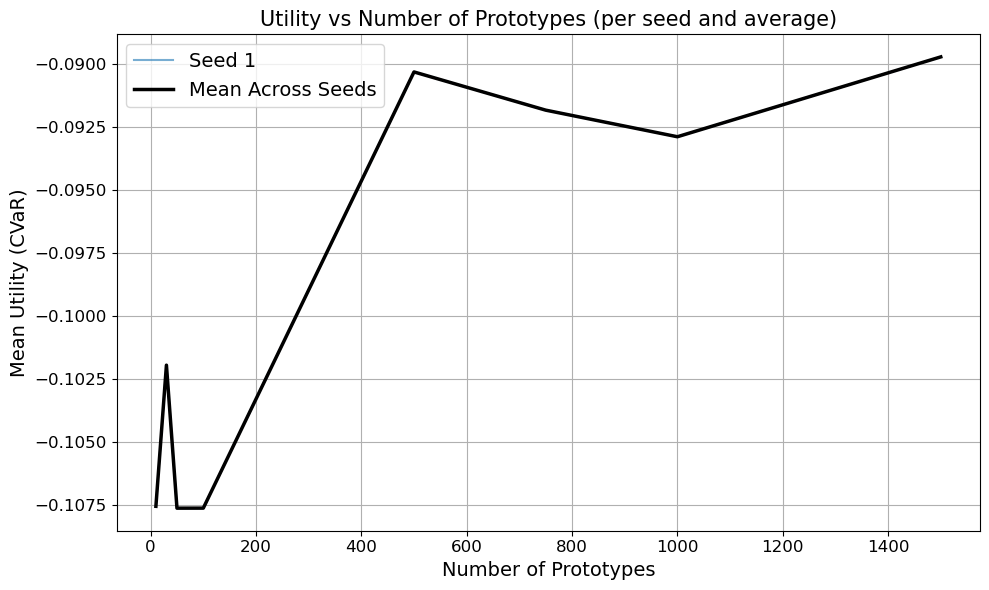

In [4]:
plot_utilities(results)

In [147]:
import matplotlib.pyplot as plt
# [30,50,600,2000,2500,3750]
def plot_mean_utility(results, exclude_last=False, exclude_proto=[]):
    seeds = sorted(results.keys())
    n_proto = sorted(next(iter(results.values())).keys())

    if exclude_last:
        n_proto = n_proto[:-1]  # optionally exclude last prototype count

    if exclude_proto is not None:
        n_proto = [n for n in n_proto if n not in exclude_proto]  # exclude specific value

    mean_utilities = []

    for n in n_proto:
        utilities_for_n = [
            results[seed][n]
            for seed in seeds
        ]
        mean_utilities.append(sum(utilities_for_n) / len(utilities_for_n))

    plt.figure(figsize=(8, 5))
    plt.plot(n_proto, mean_utilities, marker='', color='black', linewidth=2.5, label="Mean Utility (CVaR)")

    plt.xlabel("Number of Prototypes", fontsize=14)
    plt.ylabel("Mean Utility (CVaR)", fontsize=14)
    plt.grid(True)
    plt.legend()

    # Set y-axis limits to zoom out slightly
    y_min = min(mean_utilities) - 0.002
    y_max = max(mean_utilities) + 0.002
    plt.ylim(y_min, y_max)

    plt.tight_layout()
    plt.show()

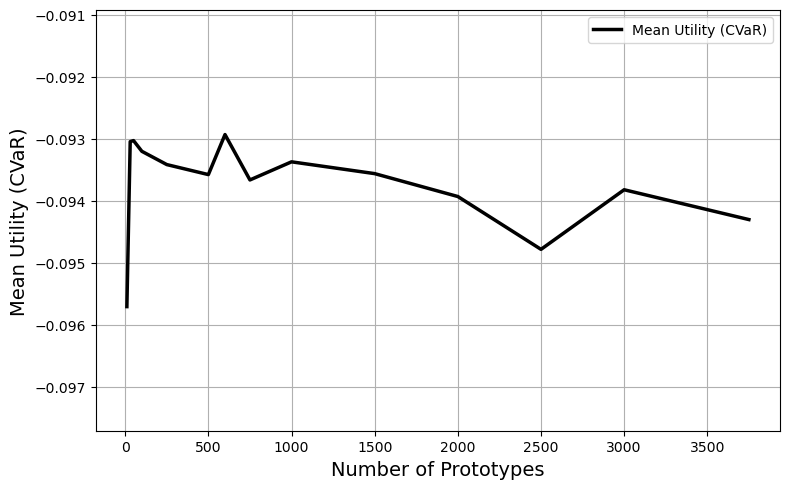

In [148]:
plot_mean_utility(results)